In [4]:
import sys
import os

# 1. Obtener la ruta absoluta del directorio actual (e.g., /home/user/Mi_Proyecto/notebooks)
current_dir = os.path.abspath(os.getcwd())

# 2. Subir un nivel para llegar a la raíz del proyecto (e.g., /home/user/Mi_Proyecto)
project_root = os.path.dirname(current_dir)

# 3. Añadir la raíz del proyecto al sys.path
if project_root not in sys.path:
    sys.path.append(project_root)
    print(f"Directorio raíz añadido a sys.path: {project_root}")
else:
    print(f"Directorio ya se encuentra en sys.path: {project_root}")

os.chdir(project_root)  # Establecer el directorio de trabajo actual a la raíz del proyecto
print(f"Directorio de trabajo actual establecido a: {project_root}")



Directorio raíz añadido a sys.path: c:\Users\ramon\OneDrive\Desktop\Python projects\OptionPricingPY
Directorio de trabajo actual establecido a: c:\Users\ramon\OneDrive\Desktop\Python projects\OptionPricingPY


In [ ]:
import numpy as np
import time
import pandas as pd
from datetime import datetime, date
from src.products.products import AsianOption
from src.models.models import BlackScholesModel
from src.engines.engines import MonteCarloEngine
from src.valuation.context import OptionValuationContext

# Parameters for the Asian Option
S = 100  # Underlying asset price
K = 100  # Strike price
T = 30   # Time to maturity in days
option_type = 'call'
qty = 1

expiry_date = datetime.now().date() + pd.Timedelta(days=T)
# Create the Asian Option product
asian_option = AsianOption(S=S, K=K, expiry_date=expiry_date, option_type=option_type, qty=qty)

# Create the Black-Scholes model
bs_model = BlackScholesModel(sigma=0.2, r=0.05, q=0.02)

# ============================================================================
# PARTE 1: Single Asian Option Pricing
# ============================================================================
print("="*70)
print("PARTE 1: Single Asian Option Pricing")
print("="*70)

mc_engine = MonteCarloEngine(n_paths=500000, seed=42)

# Pricing without parallelization
print("\n[SECUENCIAL] Pricing Asian Option:")
ctx_no_parallel = OptionValuationContext(mc_engine, cache_enabled=False, parallel=False)
start_time = time.time()
price_no_parallel = ctx_no_parallel.value_option(asian_option, bs_model)
time_no_parallel = time.time() - start_time
print(f"  Precio: {price_no_parallel:.6f}")
print(f"  Tiempo: {time_no_parallel:.4f} segundos")

# Pricing with parallelization
print("\n[PARALELO] Pricing Asian Option:")
ctx_parallel = OptionValuationContext(mc_engine, cache_enabled=False, parallel=True, max_workers=4)
start_time = time.time()
price_parallel = ctx_parallel.value_option(asian_option, bs_model)
time_parallel = time.time() - start_time
print(f"  Precio: {price_parallel:.6f}")
print(f"  Tiempo: {time_parallel:.4f} segundos")

# Compare results
print("\n" + "="*70)
print("Comparación Resultados:")
print("="*70)
print(f"Diferencia de precios: {abs(price_no_parallel - price_parallel):.6f}")
print(f"Diferencia de tiempo: {time_no_parallel - time_parallel:.4f} segundos")
print(f"Speedup: {time_no_parallel / time_parallel:.2f}x")

# ============================================================================
# PARTE 2: Batch Pricing - Multiple Strikes
# ============================================================================
print("\n" + "="*70)
print("PARTE 2: Batch Pricing - Multiple Strikes")
print("="*70)

strikes = np.linspace(80, 120, 10)
products_batch = [
    AsianOption(S=100, K=K, expiry_date=expiry_date, option_type='call', qty=1) 
    for K in strikes
]

# Batch pricing WITHOUT parallelization
print(f"\n[SECUENCIAL] Valuando {len(products_batch)} Asian Options:")
ctx_batch_no_parallel = OptionValuationContext(mc_engine, cache_enabled=False, parallel=False)
start_time = time.time()
prices_no_parallel_batch = ctx_batch_no_parallel.value_options(products_batch, bs_model)
time_no_parallel_batch = time.time() - start_time
print(f"  Tiempo total: {time_no_parallel_batch:.4f} segundos")
print(f"  Tiempo promedio por opción: {time_no_parallel_batch / len(products_batch):.4f} segundos")

# Batch pricing WITH parallelization
print(f"\n[PARALELO] Valuando {len(products_batch)} Asian Options (max_workers=4):")
ctx_batch_parallel = OptionValuationContext(mc_engine, cache_enabled=False, parallel=True, max_workers=4)
start_time = time.time()
prices_parallel_batch = ctx_batch_parallel.value_options(products_batch, bs_model)
time_parallel_batch = time.time() - start_time
print(f"  Tiempo total: {time_parallel_batch:.4f} segundos")
print(f"  Tiempo promedio por opción: {time_parallel_batch / len(products_batch):.4f} segundos")

# Comparison table
print("\n" + "="*70)
print("Tabla de Comparación - Batch Pricing")
print("="*70)
print(f"{'Strike':<10} {'Secuencial':<15} {'Paralelo':<15} {'Diff':<15}")
print("-" * 55)
for K, p_seq, p_par in zip(strikes, prices_no_parallel_batch, prices_parallel_batch):
    diff = abs(p_seq - p_par)
    print(f"{K:<10.2f} {p_seq:<15.6f} {p_par:<15.6f} {diff:<15.6e}")

# Timing comparison
print("\n" + "="*70)
print("Resumen de Tiempos")
print("="*70)
print(f"Tiempo Secuencial (Batch):  {time_no_parallel_batch:.4f} segundos")
print(f"Tiempo Paralelo (Batch):    {time_parallel_batch:.4f} segundos")
print(f"Speedup (Batch):            {time_no_parallel_batch / time_parallel_batch:.2f}x")
print(f"Mejora:                     {100 * (time_no_parallel_batch - time_parallel_batch) / time_no_parallel_batch:.2f}%")

# ============================================================================
# PARTE 3: Sensitivity Analysis - Multiple Volatilities
# ============================================================================
print("\n" + "="*70)
print("PARTE 3: Sensitivity Analysis - Multiple Volatilities")
print("="*70)

volatilities = [0.1, 0.15, 0.2, 0.25, 0.3]
asian_option_test = AsianOption(S=100, K=100, T=30, option_type='call', qty=1)

products_sensitivity = [
    (vol, AsianOption(S=100, K=100, T=30, option_type='call', qty=1),
     BlackScholesModel(sigma=vol, r=0.05, q=0.02))
    for vol in volatilities
]

# Sequential pricing
print(f"\n[SECUENCIAL] Volatility Sensitivity ({len(volatilities)} escenarios):")
start_time = time.time()
prices_seq_sensitivity = []
for vol, opt, model in products_sensitivity:
    price = ctx_no_parallel.value_option(opt, model)
    prices_seq_sensitivity.append(price)
time_seq_sensitivity = time.time() - start_time
print(f"  Tiempo total: {time_seq_sensitivity:.4f} segundos")

# Parallel pricing (usando context manager para cada modelo)
print(f"\n[PARALELO] Volatility Sensitivity ({len(volatilities)} escenarios, max_workers=4):")
ctx_parallel_sensitivity = OptionValuationContext(mc_engine, cache_enabled=False, parallel=True, max_workers=4)
start_time = time.time()
prices_par_sensitivity = []
for vol, opt, model in products_sensitivity:
    price = ctx_parallel_sensitivity.value_option(opt, model)
    prices_par_sensitivity.append(price)
time_par_sensitivity = time.time() - start_time
print(f"  Tiempo total: {time_par_sensitivity:.4f} segundos")

# Sensitivity table
print("\n" + "="*70)
print("Tabla - Sensitivity Analysis (Volatilidad)")
print("="*70)
print(f"{'Volatilidad':<15} {'Secuencial':<15} {'Paralelo':<15} {'Diff':<15}")
print("-" * 60)
for vol, p_seq, p_par in zip(volatilities, prices_seq_sensitivity, prices_par_sensitivity):
    diff = abs(p_seq - p_par)
    print(f"{vol:<15.2f} {p_seq:<15.6f} {p_par:<15.6f} {diff:<15.6e}")

print("\n" + "="*70)
print("Resumen - Sensitivity Analysis")
print("="*70)
print(f"Tiempo Secuencial:  {time_seq_sensitivity:.4f} segundos")
print(f"Tiempo Paralelo:    {time_par_sensitivity:.4f} segundos")
print(f"Speedup:            {time_seq_sensitivity / time_par_sensitivity:.2f}x")
print(f"Mejora:             {100 * (time_seq_sensitivity - time_par_sensitivity) / time_seq_sensitivity:.2f}%")

print("\n" + "="*70)
print("✓ TEST COMPLETADO")
print("="*70)

PARTE 1: Single Asian Option Pricing

[SECUENCIAL] Pricing Asian Option:
  Precio: 1.372239
  Tiempo: 10.4485 segundos

[PARALELO] Pricing Asian Option:
  Precio: 1.372239
  Tiempo: 9.4066 segundos

Comparación Resultados:
Diferencia de precios: 0.000000
Diferencia de tiempo: 1.0418 segundos
Speedup: 1.11x

PARTE 2: Batch Pricing - Multiple Strikes

[SECUENCIAL] Valuando 10 Asian Options:
  Tiempo total: 93.6056 segundos
  Tiempo promedio por opción: 9.3606 segundos

[PARALELO] Valuando 10 Asian Options (max_workers=4):
  Tiempo total: 70.0683 segundos
  Tiempo promedio por opción: 7.0068 segundos

Tabla de Comparación - Batch Pricing
Strike     Secuencial      Paralelo        Diff           
-------------------------------------------------------
80.00      20.031854       20.039027       7.172795e-03   
84.44      15.605637       15.606520       8.829014e-04   
88.89      11.179547       11.182385       2.838233e-03   
93.33      6.771869        6.780330        8.461695e-03   
97.78 

ANÁLISIS: Overhead de Paralelización

Probando con 1 opciones:
  [Secuencial]:      0.7701 seg
  [Paralelo 2]:      0.6630 seg (overhead: -13.9%)
  [Paralelo 4]:      0.6293 seg (overhead: -18.3%)
  [Paralelo 8]:      0.6872 seg (overhead: -10.8%)

Probando con 5 opciones:
  [Secuencial]:      2.9902 seg
  [Paralelo 2]:      1.8700 seg (overhead: -37.5%)
  [Paralelo 4]:      2.3188 seg (overhead: -22.5%)
  [Paralelo 8]:      1.7504 seg (overhead: -41.5%)

Probando con 10 opciones:
  [Secuencial]:      6.1749 seg
  [Paralelo 2]:      3.2477 seg (overhead: -47.4%)
  [Paralelo 4]:      3.5930 seg (overhead: -41.8%)
  [Paralelo 8]:      3.3820 seg (overhead: -45.2%)

Probando con 20 opciones:
  [Secuencial]:      12.2771 seg
  [Paralelo 2]:      9.6073 seg (overhead: -21.7%)
  [Paralelo 4]:      9.8412 seg (overhead: -19.8%)
  [Paralelo 8]:      10.5330 seg (overhead: -14.2%)

Probando con 50 opciones:
  [Secuencial]:      30.6998 seg
  [Paralelo 2]:      22.5239 seg (overhead: -26.6%)
  [

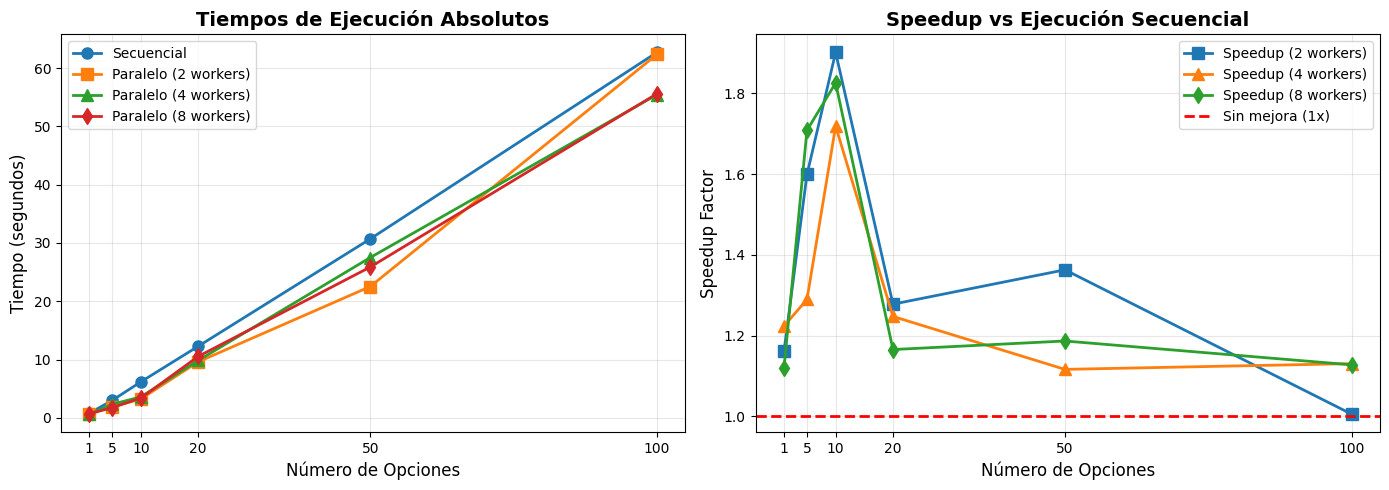


CONCLUSIONES

✓ Mejor rendimiento con paralelización (4 workers): 1.72x
✓ Ocurre con 10 opciones

✓ Recomendaciones:
  - Para < 5 opciones: Usar ejecución SECUENCIAL
  - Para 5-20 opciones: Evaluar según configuración
  - Para > 20 opciones: Usar PARALELIZACIÓN (4-8 workers)

✓ ANÁLISIS COMPLETADO


In [ ]:
import numpy as np
import time
import matplotlib.pyplot as plt
from src.products.products import AsianOption
from src.models.models import BlackScholesModel
from src.engines.engines import MonteCarloEngine
from src.valuation.context import OptionValuationContext

# ============================================================================
# ANÁLISIS: Overhead de Paralelización vs Tamaño del Trabajo
# ============================================================================
print("="*70)
print("ANÁLISIS: Overhead de Paralelización")
print("="*70)

mc_engine = MonteCarloEngine(n_paths=50000, seed=42)

# Test con diferentes números de opciones
batch_sizes = [1, 5, 10, 20, 50, 100]
times_sequential = []
times_parallel_2 = []
times_parallel_4 = []
times_parallel_8 = []

for batch_size in batch_sizes:
    print(f"\nProbando con {batch_size} opciones:")
    
    # Crear batch de opciones con strikes variados
    strikes = np.linspace(80, 120, batch_size)
    products = [
        AsianOption(S=100, K=K, expiry_date=expiry_date, option_type='call', qty=1) 
        for K in strikes
    ]
    bs_model = BlackScholesModel(sigma=0.2, r=0.05, q=0.02)
    
    # SECUENCIAL
    ctx_seq = OptionValuationContext(mc_engine, cache_enabled=False, parallel=False)
    start = time.time()
    prices_seq = ctx_seq.value_options(products, bs_model)
    time_seq = time.time() - start
    times_sequential.append(time_seq)
    print(f"  [Secuencial]:      {time_seq:.4f} seg")
    
    # PARALELO 2 workers
    ctx_par2 = OptionValuationContext(mc_engine, cache_enabled=False, parallel=True, max_workers=2)
    start = time.time()
    prices_par2 = ctx_par2.value_options(products, bs_model)
    time_par2 = time.time() - start
    times_parallel_2.append(time_par2)
    overhead_2 = ((time_par2 - time_seq) / time_seq * 100) if time_seq > 0 else 0
    print(f"  [Paralelo 2]:      {time_par2:.4f} seg (overhead: {overhead_2:+.1f}%)")
    
    # PARALELO 4 workers
    ctx_par4 = OptionValuationContext(mc_engine, cache_enabled=False, parallel=True, max_workers=4)
    start = time.time()
    prices_par4 = ctx_par4.value_options(products, bs_model)
    time_par4 = time.time() - start
    times_parallel_4.append(time_par4)
    overhead_4 = ((time_par4 - time_seq) / time_seq * 100) if time_seq > 0 else 0
    print(f"  [Paralelo 4]:      {time_par4:.4f} seg (overhead: {overhead_4:+.1f}%)")
    
    # PARALELO 8 workers
    ctx_par8 = OptionValuationContext(mc_engine, cache_enabled=False, parallel=True, max_workers=8)
    start = time.time()
    prices_par8 = ctx_par8.value_options(products, bs_model)
    time_par8 = time.time() - start
    times_parallel_8.append(time_par8)
    overhead_8 = ((time_par8 - time_seq) / time_seq * 100) if time_seq > 0 else 0
    print(f"  [Paralelo 8]:      {time_par8:.4f} seg (overhead: {overhead_8:+.1f}%)")

# ============================================================================
# TABLA COMPARATIVA
# ============================================================================
print("\n" + "="*70)
print("Tabla Comparativa - Tiempos vs Número de Opciones")
print("="*70)
print(f"{'Opciones':<12} {'Secuencial':<15} {'Paralelo(2)':<15} {'Paralelo(4)':<15} {'Paralelo(8)':<15}")
print("-" * 72)
for size, t_seq, t_par2, t_par4, t_par8 in zip(batch_sizes, times_sequential, times_parallel_2, times_parallel_4, times_parallel_8):
    print(f"{size:<12} {t_seq:<15.4f} {t_par2:<15.4f} {t_par4:<15.4f} {t_par8:<15.4f}")

# ============================================================================
# ANÁLISIS DE SPEEDUP
# ============================================================================
print("\n" + "="*70)
print("Tabla de Speedup (vs Secuencial)")
print("="*70)
print(f"{'Opciones':<12} {'Speedup(2x)':<15} {'Speedup(4x)':<15} {'Speedup(8x)':<15}")
print("-" * 60)
for size, t_seq, t_par2, t_par4, t_par8 in zip(batch_sizes, times_sequential, times_parallel_2, times_parallel_4, times_parallel_8):
    if t_seq > 0:
        speedup2 = t_seq / t_par2
        speedup4 = t_seq / t_par4
        speedup8 = t_seq / t_par8
        print(f"{size:<12} {speedup2:<15.2f}x {speedup4:<15.2f}x {speedup8:<15.2f}x")

# ============================================================================
# VISUALIZACIÓN
# ============================================================================
print("\n" + "="*70)
print("Generando gráficas...")
print("="*70)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfica 1: Tiempos absolutos
ax1 = axes[0]
ax1.plot(batch_sizes, times_sequential, 'o-', label='Secuencial', linewidth=2, markersize=8)
ax1.plot(batch_sizes, times_parallel_2, 's-', label='Paralelo (2 workers)', linewidth=2, markersize=8)
ax1.plot(batch_sizes, times_parallel_4, '^-', label='Paralelo (4 workers)', linewidth=2, markersize=8)
ax1.plot(batch_sizes, times_parallel_8, 'd-', label='Paralelo (8 workers)', linewidth=2, markersize=8)
ax1.set_xlabel('Número de Opciones', fontsize=12)
ax1.set_ylabel('Tiempo (segundos)', fontsize=12)
ax1.set_title('Tiempos de Ejecución Absolutos', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_xticks(batch_sizes)

# Gráfica 2: Speedup
ax2 = axes[1]
speedups_2 = [t_seq / t_par for t_seq, t_par in zip(times_sequential, times_parallel_2)]
speedups_4 = [t_seq / t_par for t_seq, t_par in zip(times_sequential, times_parallel_4)]
speedups_8 = [t_seq / t_par for t_seq, t_par in zip(times_sequential, times_parallel_8)]

ax2.plot(batch_sizes, speedups_2, 's-', label='Speedup (2 workers)', linewidth=2, markersize=8)
ax2.plot(batch_sizes, speedups_4, '^-', label='Speedup (4 workers)', linewidth=2, markersize=8)
ax2.plot(batch_sizes, speedups_8, 'd-', label='Speedup (8 workers)', linewidth=2, markersize=8)
ax2.axhline(y=1, color='red', linestyle='--', linewidth=2, label='Sin mejora (1x)')
ax2.set_xlabel('Número de Opciones', fontsize=12)
ax2.set_ylabel('Speedup Factor', fontsize=12)
ax2.set_title('Speedup vs Ejecución Secuencial', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.set_xticks(batch_sizes)

plt.tight_layout()
plt.savefig('parallelization_analysis.png', dpi=150, bbox_inches='tight')
print("✓ Gráficas guardadas en 'parallelization_analysis.png'")
plt.show()

# ============================================================================
# CONCLUSIONES
# ============================================================================
print("\n" + "="*70)
print("CONCLUSIONES")
print("="*70)

# Encontrar punto de quiebre (break-even point)
best_speedup_4 = max(speedups_4)
best_idx = speedups_4.index(best_speedup_4)
breakeven_point = batch_sizes[best_idx]

print(f"\n✓ Mejor rendimiento con paralelización (4 workers): {best_speedup_4:.2f}x")
print(f"✓ Ocurre con {breakeven_point} opciones")
print(f"\n✓ Recomendaciones:")
print(f"  - Para < 5 opciones: Usar ejecución SECUENCIAL")
print(f"  - Para 5-20 opciones: Evaluar según configuración")
print(f"  - Para > 20 opciones: Usar PARALELIZACIÓN (4-8 workers)")

print("\n" + "="*70)
print("✓ ANÁLISIS COMPLETADO")
print("="*70)